## Continental China

Description of the Models:
- Location: E. Asia including China, Korean Peninsula, Sea of Japan and Japan;
- Stations: CEArray, China Array, Korean Seismic Network, NECESS Array, PASSCAL array, and KNET.
- Data: Rayleigh wave phase and group measurements.
- Tomography: Ambient Noise: ray theory (Barmin et al., 2001), 8-50 sec
- Earthquakes: Eikonal/Helmholtz tomography for phase velocity in certain areas, 30-70 sec.
- Parameterization: 1 gradient sedimentary layer, 5 cubic B-splines in the crystalline crust, 5 cubic B-
splines in the mantle. For offshore regions, 1 water layer is at the top of the solid earth.
- Inversion: Monte Carlo model space sampling.
- Forward code: Herrmann
- Moho: Variable
- Format of Vs model file: China_2015_Vs_v1.0.tar
- The resulting model appears in directory China_2015_Vs_v1.0 separately as a set of 1-D models
for each grid point. At each location the model is not the original model file from the inversion
that is parameterized in gradient layers and B-splines, **but interpolated at regular depth points**.

Example of Source Data:
- For example, there is file 110_40.mod, for (lat, lon) = (40, 110). The first few kms look as
follows:
  - Depth from Surface(km) Vs(km/sec) Uncertainty of Vs(km/sec)
    ```
    0 1.56997 0.477791
    0.5 2.04501 0.335994
    1 2.93673 0.177576
    1.5 3.02941 0.170671
    2 3.108 0.186244
    2.5 3.14888 0.163531
    ```

Reference
- Shen, W., Ritzwoller, M. H., Kang, D., Kim, Y., Lin, F.-C., Ning, J., Wang, W., Zheng, Y., & Zhou, L. (2016). A seismic reference model for the crust and uppermost mantle beneath china from surface wave dispersion. Geophysical Journal International, 206(2), 954–979. https://doi.org/10.1093/gji/ggw175


Pages: 
- http://ds.iris.edu/ds/products/emc-us2016
- http://ciei.colorado.edu/DispMaps/

## Step0: Downloading & Loading the Source Datasets

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

In [ ]:
data_path = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/Shen2016_china/China_2015_Vs_v1.0"
files = os.listdir(data_path)
len(files),files[0]

(4527, '100.5_23.mod')

In [4]:
# reading the given vs and depth
temp_loc,temp_data = [],[]
max_len = 0
for file in files:
    data = np.loadtxt(os.path.join(data_path,file))
    if len(data)>0:
        file = file.replace(".mod","").split("_")
        lon,lat = float(file[0]),float(file[1])
        temp_loc.append([lon,lat])
        temp_data.append(data[:,:2])
        max_len = np.max([max_len,data.shape[0]])
vs = np.ones(((len(temp_data),max_len,2)))*-1
for i,data in enumerate(temp_data):
    vs[i,:len(data),:] = data
    vs[i,len(data):,:] = vs[i,len(data)-1,:]
loc = np.array(temp_loc)
vs = np.array(vs)
lon,lat = loc[:,0],loc[:,1]
loc.shape,vs.shape

/tmp/ipykernel_1354068/183684253.py:5: UserWarning: loadtxt: input contained no data: "/home/bingxing2/ailab/scxlab0055/project/04_Inversion/SurfWaveInv/OpenSWI/Datasets/OpenSWI/Datasets/Original/OpenSWI-deep/Shen2016_china/China_2015_Vs_v1.0/100.5_44.5.mod"
  data = np.loadtxt(os.path.join(data_path,file))
/tmp/ipykernel_1354068/183684253.py:5: UserWarning: loadtxt: input contained no data: "/home/bingxing2/ailab/scxlab0055/project/04_Inversion/SurfWaveInv/OpenSWI/Datasets/OpenSWI/Datasets/Original/OpenSWI-deep/Shen2016_china/China_2015_Vs_v1.0/102_47.mod"
  data = np.loadtxt(os.path.join(data_path,file))
/tmp/ipykernel_1354068/183684253.py:5: UserWarning: loadtxt: input contained no data: "/home/bingxing2/ailab/scxlab0055/project/04_Inversion/SurfWaveInv/OpenSWI/Datasets/OpenSWI/Datasets/Original/OpenSWI-deep/Shen2016_china/China_2015_Vs_v1.0/102.5_47.mod"
  data = np.loadtxt(os.path.join(data_path,file))
/tmp/ipykernel_1354068/183684253.py:5: UserWarning: loadtxt: input contained no

((4516, 2), (4516, 400, 2))

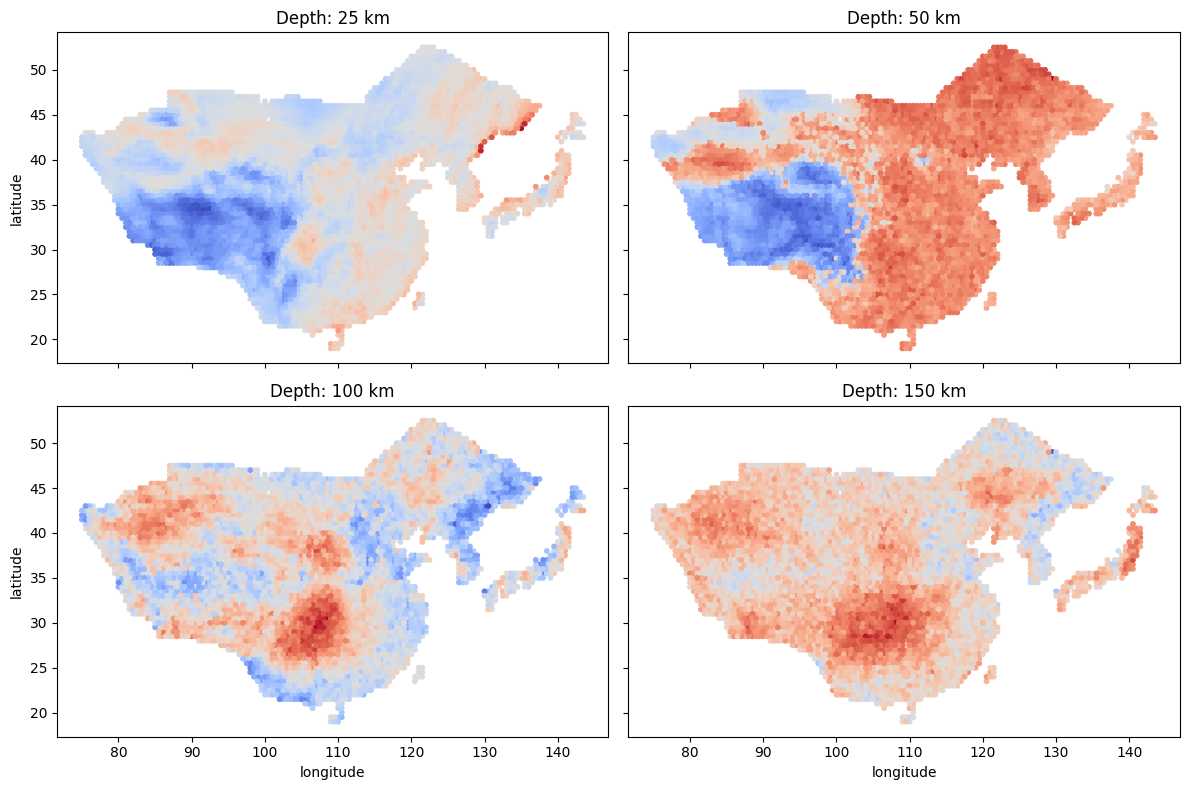

In [4]:
# plot the 
nrows,ncols = 2,2
fig,axs = plt.subplots(nrows,ncols,figsize=(12,8))
depth_idxs = [50,100,200,300]

for i in range(nrows):
    for j in range(ncols):
        depth_idx = depth_idxs[i*ncols+j]
        axs[i,j].scatter(lon,lat,c=vs[:,depth_idx,1],cmap='coolwarm', s=10)
        axs[i,j].set_title('')
        if i == nrows-1:
            axs[i,j].set_xlabel('longitude')
        else:
            axs[i,j].tick_params(labelbottom=False)
        if j == 0:
            axs[i,j].set_ylabel('latitude')
        else:
            axs[i,j].tick_params(labelleft=False)
        axs[i,j].set_title(f'Depth: {int(vs[0,depth_idx,0])} km')
plt.tight_layout()
plt.show()

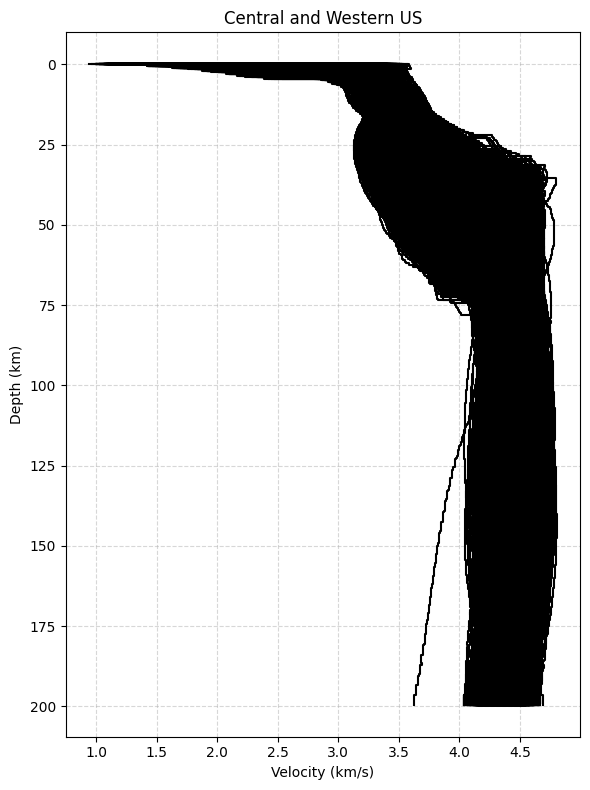

In [5]:
# single station comparsion
plt.figure(figsize=(6,8))
for i in range(vs.shape[0]):
    mask = vs[i,:,1] > 0
    plt.step(vs[i,mask,1],vs[i,mask,0],where='post',c='k')
plt.gca().invert_yaxis()
plt.grid(linestyle='--',alpha=0.5)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Depth (km)')
plt.title('Central and Western US')
plt.tight_layout()
plt.show()

## Step 2: Quality Control & Interpolation

In [ ]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [7]:
depth = vs[:,:,0]
vs = vs[:,:,1]

In [8]:
# -------------------------------------------------------
#  interpolation
# -------------------------------------------------------
from scipy.interpolate import interp1d
max_depth = 300+0.1
depth_interp = np.concatenate([
    np.arange(0, max_depth, 1)
])
vs_models = vs_interp = np.zeros((vs.shape[0],depth_interp.shape[0]))
for i in range(vs.shape[0]):
    vs_temp = vs[i,:]
    depth_temp = depth[i,:]
    depth_interp_temp = depth_interp[:np.argmin(np.abs(depth_interp-depth_temp.max()))]
    f = interp1d(depth_temp.reshape(-1),vs_temp,kind='nearest')
    vs_temp = f(depth_interp_temp)
    vs_interp[i,:len(vs_temp)] = vs_temp
vs_interp[:,len(vs_temp):] = vs_interp[:,len(vs_temp)-1].reshape(-1,1)
vs_interp.shape

(4516, 301)

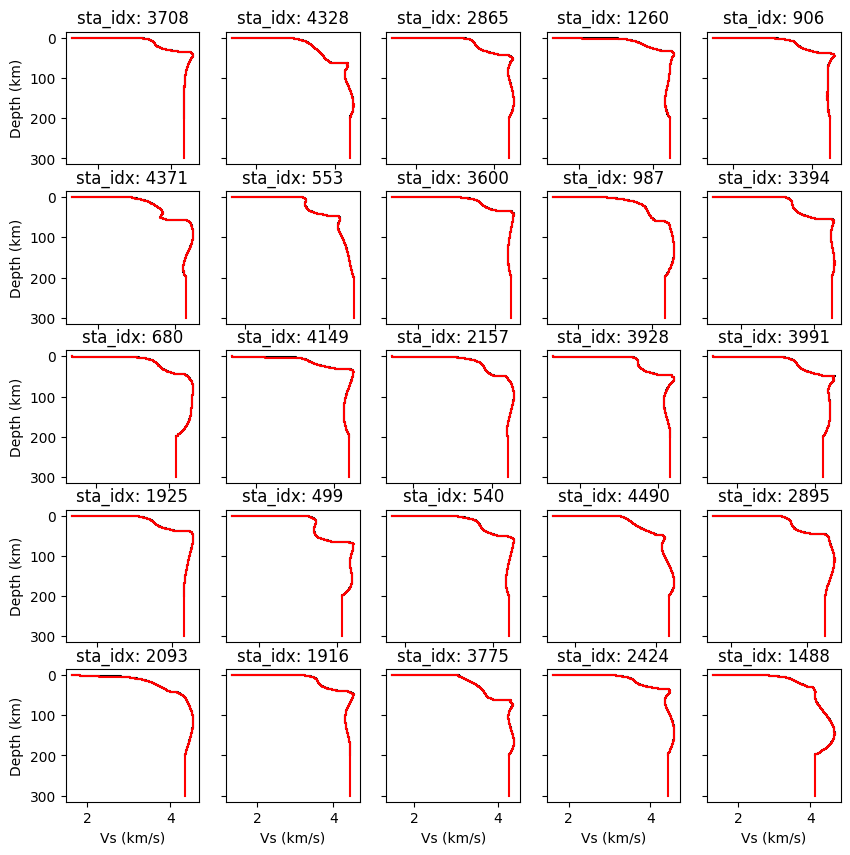

In [9]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        mask = vs[sta_idx]>0
        axs[i,j].step(vs[sta_idx,mask],depth[sta_idx,mask],c='k')
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [10]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [12]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/4516 [00:00<?, ?it/s]

(4516, 301)

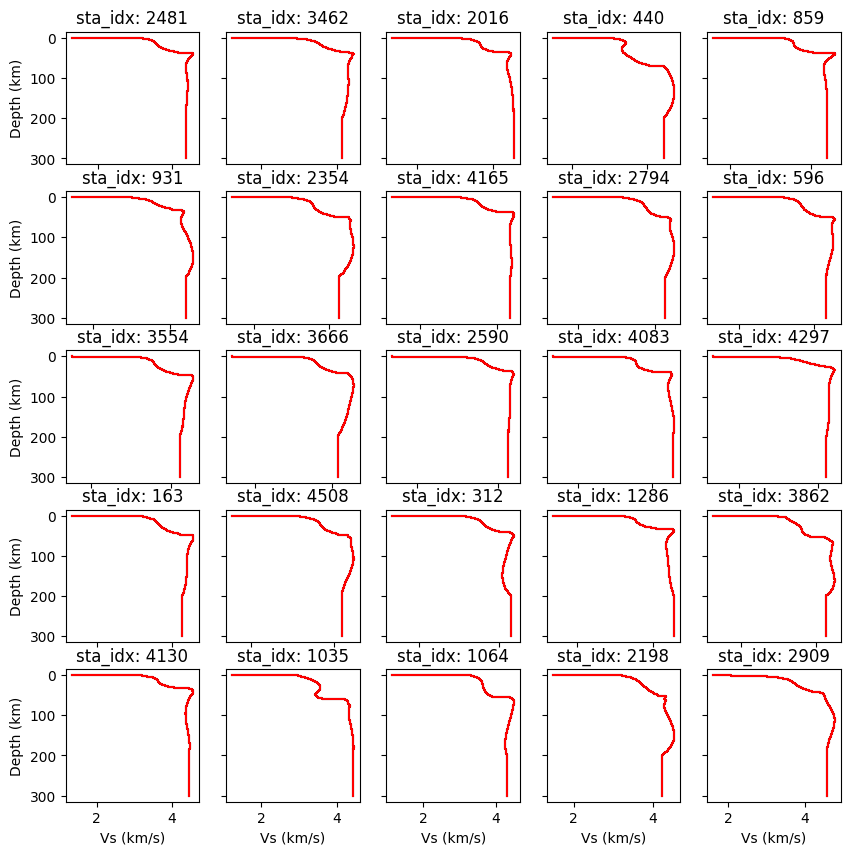

In [11]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Find the Moho 

In [12]:
moho_idxs = p_map(find_moho_depth,
                  vs_interp_rm_sandwich,
                  list(depth_interp.reshape(1,-1))*len(vs_interp_rm_sandwich),
                  [[5,90]]*len(vs_interp_rm_sandwich),
                  [True]*len(vs_interp_rm_sandwich),
                  [0.05]*len(vs_interp_rm_sandwich),
                  [2]*len(vs_interp_rm_sandwich))
moho_idxs = np.array(moho_idxs)
moho_idxs.shape

  0%|          | 0/4516 [00:00<?, ?it/s]

(4516,)

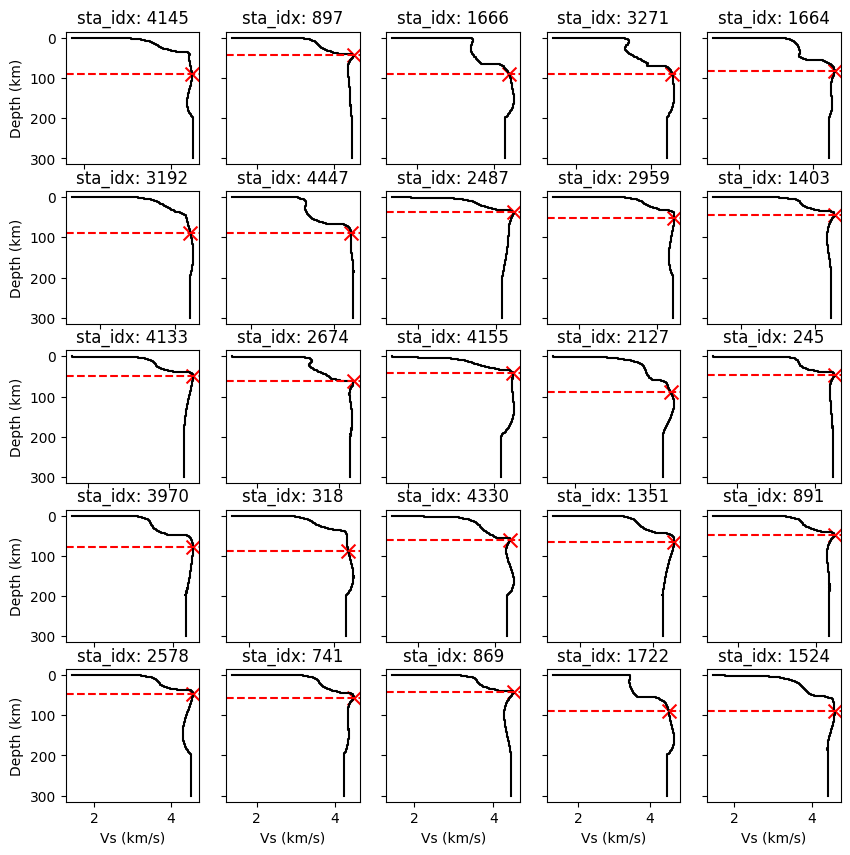

In [13]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        moho_depth_idx = moho_idxs[sta_idx]
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='k')
        axs[i,j].axhline(y = depth_interp[moho_depth_idx],color='r',linestyle='--')
        axs[i,j].scatter(vs_interp_rm_sandwich[sta_idx,moho_depth_idx],depth_interp[moho_depth_idx],c='r',marker='x',s=100)
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 4: Perturbation the Moho depth and velocity

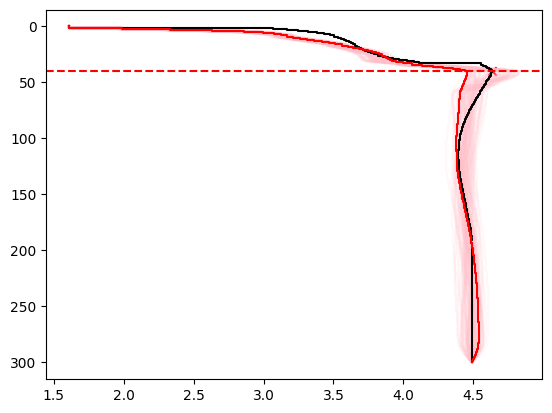

(100, 301)

In [14]:
# Generate perturbed models single
i = 2000
vs_orig = vs_interp_rm_sandwich[i]
# Find Moho
moho_idx = moho_idxs[i]
plt.figure()
plt.step(vs_orig,depth_interp,c='k')
plt.scatter(vs_orig[moho_idx],depth_interp[moho_idx],c='r',marker='x')
plt.axhline(y=depth_interp[moho_idx],color='r',linestyle='--')

vs_perts = []
perturb_num = 100
random_seeds = np.random.randint(0,1000000,perturb_num)
for i in range(perturb_num):
    # Generate perturbed profile
    vs_pert, controle_node_t, controle_node_vs = augment_crust_moho_mantle(vs_orig, 
                                                                depth_interp, 
                                                                moho_idx, 
                                                                vs_perturb_range=[-0.2,0.2],
                                                                crust_nodes_range=[3,8],
                                                                mantle_nodes_range=[8,12],
                                                                moho_shift_range=5,
                                                                gaussian_smooth_sigma=2,
                                                                return_nodes=True,
                                                                random_seed=random_seeds[i])
    # plot the perturbed profile
    plt.step(vs_pert,depth_interp,c='pink' if i !=0 else 'r',alpha=0.1 if i !=0 else 1, zorder=1 if i !=0 else 2)
    # plt.scatter(controle_node_vs,controle_node_t,c='b',alpha=0.2)
    vs_perts.append(vs_pert)
vs_perts = np.array(vs_perts)
plt.gca().invert_yaxis()
plt.show()
np.unique(vs_perts,axis=0).shape

In [16]:
vs_interp_rm_sandwich.shape,moho_idxs.shape

((4516, 301), (4516,))

In [17]:
perturb_num = 5
aug_vs_list = [vs_interp_rm_sandwich]
for i in range(perturb_num):
    # perturb the moho depth and velocity 1 time
    random_seeds = np.random.randint(0,1000000,len(vs_interp_rm_sandwich))
    aug_vs_list_temp = p_map(augment_crust_moho_mantle,
                                vs_interp_rm_sandwich,
                                list(depth_interp.reshape(1,-1))*len(vs_interp_rm_sandwich),
                                moho_idxs,
                                [[-0.2,0.2]]*len(vs_interp_rm_sandwich),
                                [[3,8]]*len(vs_interp_rm_sandwich),
                                [[8,12]]*len(vs_interp_rm_sandwich),
                                [5]*len(vs_interp_rm_sandwich),
                                [2]*len(vs_interp_rm_sandwich),
                                [False]*len(vs_interp_rm_sandwich),
                                random_seeds)
    aug_vs_list.append(aug_vs_list_temp)
aug_vs_list = np.array(aug_vs_list)
aug_vs_list.shape

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

(6, 4516, 301)

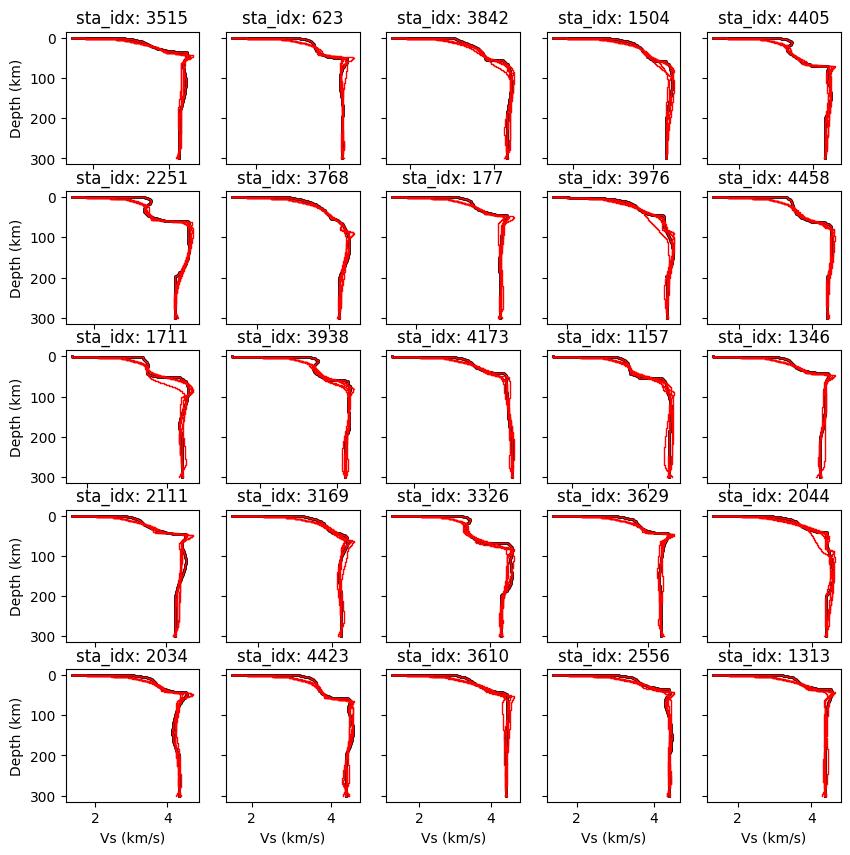

In [18]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs_interp_rm_sandwich))
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='k',label='original', linewidth=2)

        for k in range(perturb_num):
            axs[i,j].step(aug_vs_list[k,sta_idx,:],depth_interp,c='r',label='perturbed' if k == 0 else None, linewidth=1)

        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 5: Dispersion Curve Forward Modeling

In [22]:
vs_models = aug_vs_list.reshape(-1,aug_vs_list.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/27096 [00:00<?, ?it/s]

(27096, 301, 4)

In [23]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/27096 [00:00<?, ?it/s]

((27096, 301, 4), (27096, 300, 3))

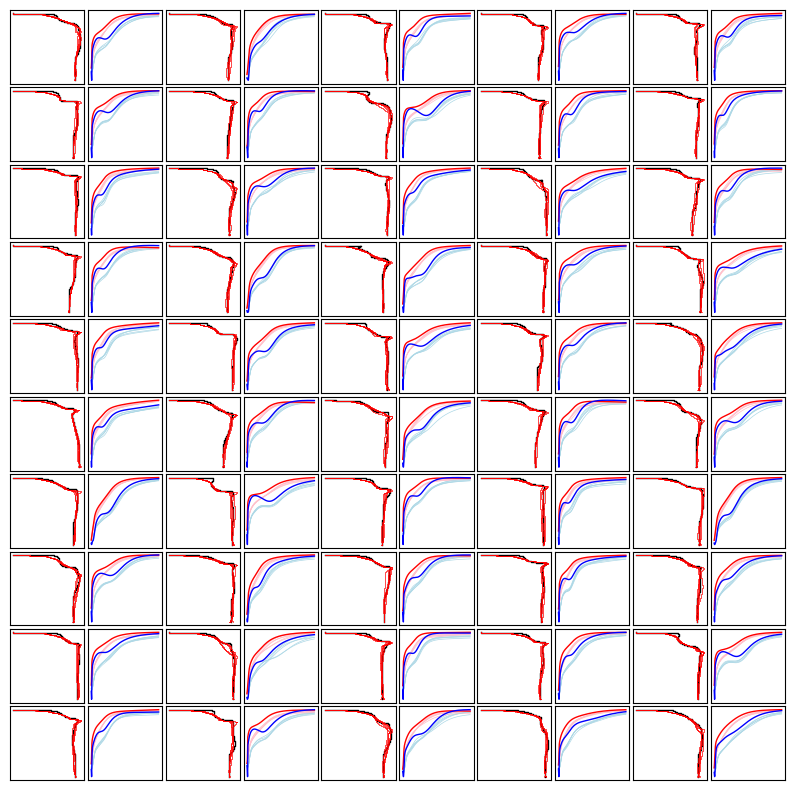

In [24]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vs_interp_rm_sandwich.shape[0])
        
        # velocity profile
        for k in range(perturb_num+1):
            axs[i,j*2].step(vel_models[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,2],
                            vel_models[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                            linewidth=1 if k == 0 else 0.5,color='k' if k == 0 else 'r')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        for k in range(perturb_num+1):
            axs[i,j*2+1].plot(disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                                 disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,1],
                                 linewidth=1 if k==0 else 0.5,c='r' if k==0 else "pink", zorder=2 if k==0 else 1)
            axs[i,j*2+1].plot(disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                                 disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,2],
                                 linewidth=1 if k==0 else 0.5,c='b' if k==0 else "lightblue", zorder=2 if k==0 else 1)
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [27]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

# loc = loc[mask,:]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]
loc.shape,vel_models.shape,disp_data.shape

((4516, 2), (27096, 301, 4), (27096, 300, 3))

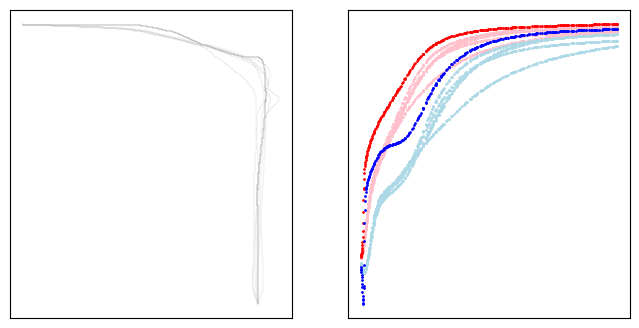

In [30]:
fig,axs = plt.subplots(1,2,figsize=(8,4))

sta_idx = np.random.randint(0,vs_interp_rm_sandwich.shape[0])
        
# velocity profile
for k in range(perturb_num+1):
    axs[0].step(vel_models[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,2],
                    vel_models[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                    linewidth=0.2,color='k' if k == 0 else 'silver')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].invert_yaxis()

# dispersion curve
for k in range(perturb_num+1):
    axs[1].scatter(disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                            disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,1],
                            s=1,c='r' if k==0 else "pink", zorder=2 if k==0 else 1)
    axs[1].scatter(disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,0],
                            disp_data[k*vs_interp_rm_sandwich.shape[0]+sta_idx][:,2],
                            s=1,c='b' if k==0 else "lightblue", zorder=2 if k==0 else 1)
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Aug"
# Save processed data as compressed npz files
# np.savez_compressed(os.path.join(save_base_path, "Continantle_China_Shen2016_loc.npz"),
#                     data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "Continental_China_Shen2016_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "Continental_China_Shen2016_disp.npz"),
                    data=disp_data.astype(np.float32))

(array([64., 33., 28., 24., 30., 25., 20., 25., 24., 27.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

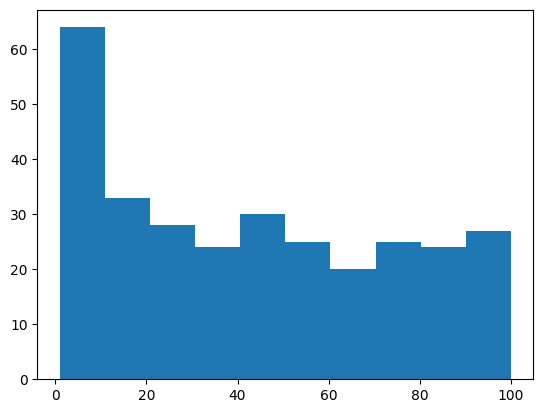

In [29]:
plt.hist(disp_data[0,:,0])